# Macroeconomic indicators for Bitcoin

In the world of cryptocurrency, bitcoin is by far the largest crypto in the asset class. As such, it is useful to study the price action and its relative value in order to navigate through the market cycle. This project is meant to study the previous price actions and macroeconomic trends of bitcoin, in order for us to get a sense of where the currency is at in the larger market cycle.

This project will mainly cover three indicators
1. Extension from its fairvalue
2. Market cycle ROI (as measured from the bottom)
3. Logarithmic regression hallway

We will be using bitcoin marketprice data from quandl: https://data.nasdaq.com/data/BCHAIN/MKPRU-bitcoin-market-price-usd

In [63]:
# Basic Libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

# Data preprocessing

In [64]:
btcdata = pd.read_csv('BCHAIN-MKPRU.csv')
btcdata.head()

,Date,Value
0,2021-10-08,53801.10
1,2021-10-07,55343.76
2,2021-10-06,51505.83
3,2021-10-05,49143.95
4,2021-10-04,48205.72


Since this data set is updated daily, the newer data is appended to the front, we will need to reverse the entire data set

In [65]:
# Reverse the entire dataset
btcdata = btcdata.reindex(index=btcdata.index[::-1])
# Convert into pandas date format
btcdata["Date"] = pd.to_datetime(btcdata["Date"])
# Fill up Null/NA values
btcdata['Value'].fillna(method='ffill', inplace=True)
btcdata.head()

,Date,Value
4662,2009-01-02,0.0
4661,2009-01-03,0.0
4660,2009-01-04,0.0
4659,2009-01-05,0.0
4658,2009-01-06,0.0


In [66]:
weekly_data = btcdata.groupby([pd.Grouper(key='Date', freq='W-MON')]).first().reset_index()
weekly_data.head()

,Date,Value
0,2009-01-05,0.0
1,2009-01-12,0.0
2,2009-01-19,0.0
3,2009-01-26,0.0
4,2009-02-02,0.0


In [67]:
# Iterate through the rows and find which are 0 values
# Values that are NA were filled, only initial values are 0 due to rounding
for index,row in btcdata.iterrows():
    # -1 are all the anomalies
    if row["Value"] == 0.0:
        # Drop all 0 valuesto "clean the data"
        btcdata = btcdata.drop(index)
# Reindex the data
btcdata = btcdata.reset_index(drop=True)

# Basic Exploration
We will be visualising the price action of bitcoin by plottint its price against time. 
Since bitcoin is known to have growth that spans orders of magnitudes, we will be using a logartihmic scale to account for skewness in the data

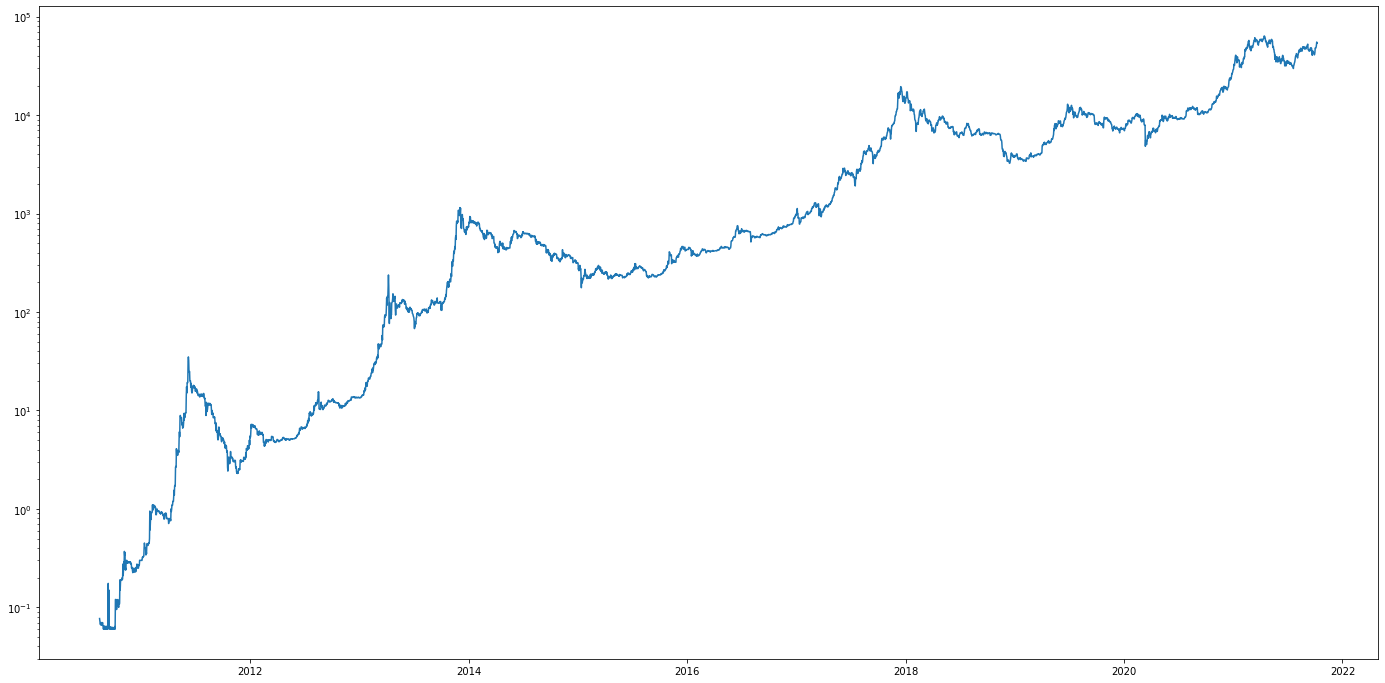

In [68]:
fig = plt.figure(figsize=(24, 12))
ax = plt.gca()
ax.set_yscale('log')
#Plots Closing Price of Bitcoin against time 
plt.plot(btcdata["Date"],btcdata["Value"])

From this graph, we can see that there are a few distinctive peaks on the bitcoin graph, one in 2011, 2013 and 2018. Its clear that bitcoin goes through cycles that lasts a few years. The purpose is to use data from this prior cycles to try to predict the price action for this cycle.

In [82]:
# I want to add labels for the peaks as long as the halving lines, but that will be done after I implement the deviation thingy
# First peak 2011
first_peak = btcdata.loc[btcdata["Date"].isin(pd.date_range("2011-03-01", "2012-01-01"))].max()
# Extracts the date of the first peak, by matching the max value within the date range to the date where it ocurred
print(btcdata.loc[btcdata['Value'] == first_peak["Value"],'Date'])
print(first_peak["Value"])
# Second Peak 2013
second_peak = btcdata.loc[btcdata["Date"].isin(pd.date_range("2013-01-01", "2014-06-01"))].max()
print(btcdata.loc[btcdata['Value'] == second_peak["Value"],'Date'])
print(second_peak["Value"])
# Third Peak 2018
third_peak = btcdata.loc[btcdata["Date"].isin(pd.date_range("2017-01-01", "2018-06-01"))].max()
print(btcdata.loc[btcdata['Value'] == third_peak["Value"],'Date'])
print(third_peak["Value"])

peakdata = pd.DataFrame(columns=['Date', 'Value'])
peakdata = peakdata.append({'Date': "2011-06-09" , 'Value': 35}, ignore_index=True)
peakdata = peakdata.append({'Date': "2013-12-03" , 'Value': 1151}, ignore_index=True)
peakdata = peakdata.append({'Date': "2017-12-16" , 'Value': 19498.6833333}, ignore_index=True)
peakdata.head()

296   2011-06-09
Name: Date, dtype: datetime64[ns]
35.0
1204   2013-12-03
Name: Date, dtype: datetime64[ns]
1151.0
2678   2017-12-16
Name: Date, dtype: datetime64[ns]
19498.6833333


,Date,Value
0,2011-06-09,35
1,2013-12-03,1151
2,2017-12-16,19498.683333


# Part 1: Deviation from the fairvalue as estimated with Moving Averages

In [70]:
# Calculates the 20 week simple moving average
sma_20 = weekly_data["Value"].rolling(window = 20).mean()
weekly_data["SMA_20"] = sma_20
# Calculates the 21 week exponential moving average
ema_21 = weekly_data["Value"].ewm(span = 21, adjust = False).mean()
weekly_data["EMA_21"] = ema_21
weekly_data.head()

,Date,Value,SMA_20,EMA_21
0,2009-01-05,0.0,NaN,0.0
1,2009-01-12,0.0,NaN,0.0
2,2009-01-19,0.0,NaN,0.0
3,2009-01-26,0.0,NaN,0.0
4,2009-02-02,0.0,NaN,0.0


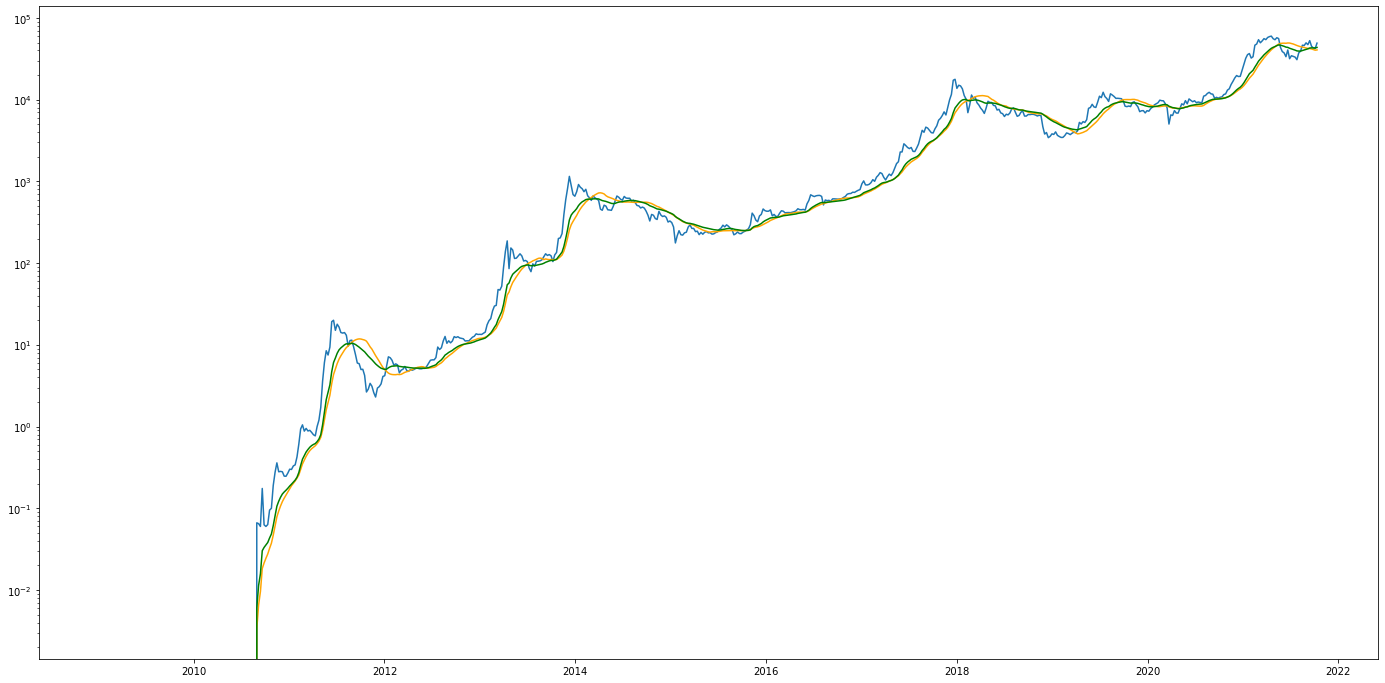

In [71]:
fig = plt.figure(figsize=(24, 12))
#Plots Closing Price of Bitcoin against time with the bull market support band
ax = plt.gca()
ax.set_yscale('log')
plt.plot(weekly_data["Date"],weekly_data["Value"])
plt.plot(weekly_data["Date"], weekly_data["SMA_20"], color = 'orange')
plt.plot(weekly_data["Date"], weekly_data["EMA_21"], color = 'green')

In [72]:
#Find the average between 20WMA, 21WEMA. This will be the estimated "Fair Value" based on the moving averages
weekly_data["Fairvalue_MA"] = weekly_data[["SMA_20","EMA_21"]].mean(axis =1)
#Find the deviation as a percentage of the bull market support band (i.e. 100% = 1)
weekly_data["Deviation_MA"] = weekly_data["Value"]/weekly_data["Fairvalue_MA"] *100
weekly_data.head()

,Date,Value,SMA_20,EMA_21,Fairvalue_MA,Deviation_MA
0,2009-01-05,0.0,NaN,0.0,0.0,NaN
1,2009-01-12,0.0,NaN,0.0,0.0,NaN
2,2009-01-19,0.0,NaN,0.0,0.0,NaN
3,2009-01-26,0.0,NaN,0.0,0.0,NaN
4,2009-02-02,0.0,NaN,0.0,0.0,NaN


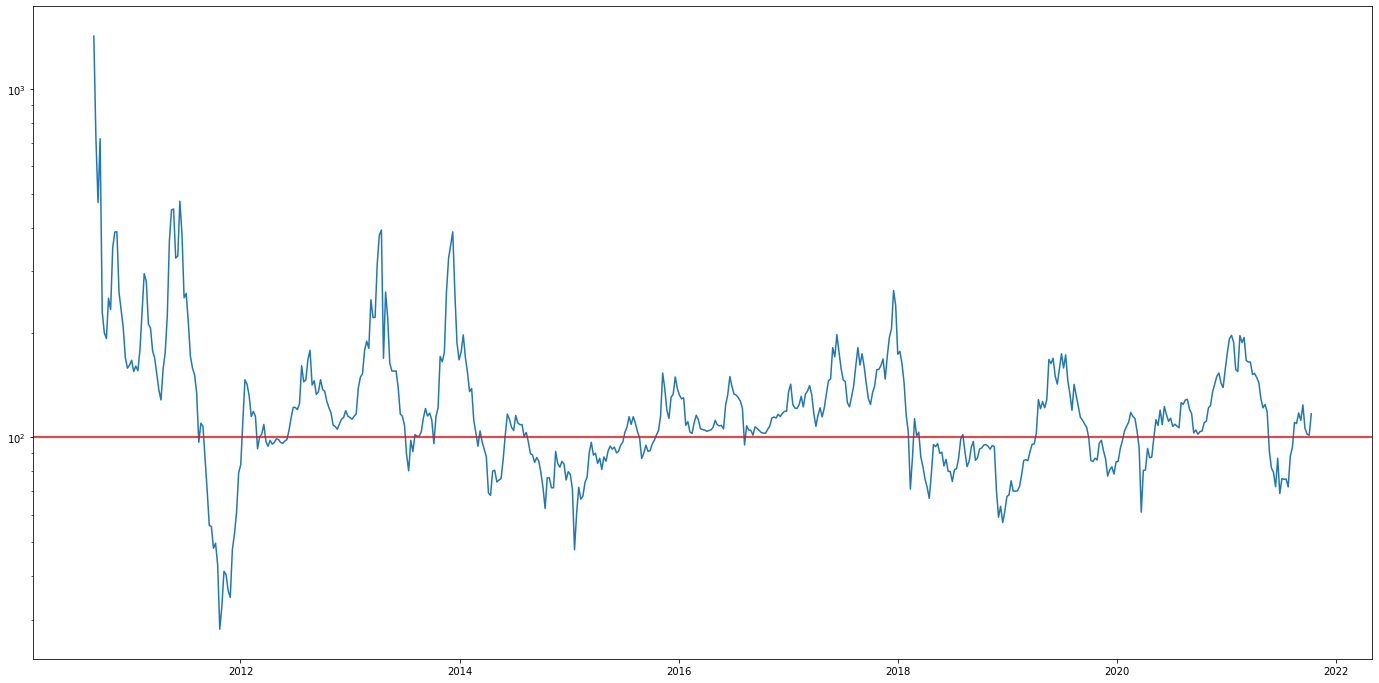

In [73]:
fig = plt.figure(figsize=(24, 12))
# Plots the deviation with respect to time
plt.plot(weekly_data["Date"],weekly_data["Deviation_MA"])
# Red line represents the "Fair Value" at any given time
ax = plt.gca()
ax.set_yscale('log')
plt.axhline(y=100, color='r', linestyle='-')

# Part 2: Comparing previous Market Cycle ROI as measured from the bottom
Identify the peaks and the bottoms of the market cycle, in order to measure the length of each cycle as well as the ROI of each cycle and compare the difference if there is a relationship, use it to project the future ROI as well as the length of the current cycle
1. Plot the BTC USD chart on log scale and identify cycles
2. Use range max and min to find the market cycle top and bottom
3. Using the date range of the top and bottom, to segment the data sets into three cycles (one cycle one dataframe)
3. Take the percentage of the data with respect to the bottom for all three cycles
4. Plot the days from bottom with the ROI to see the difference between cycles

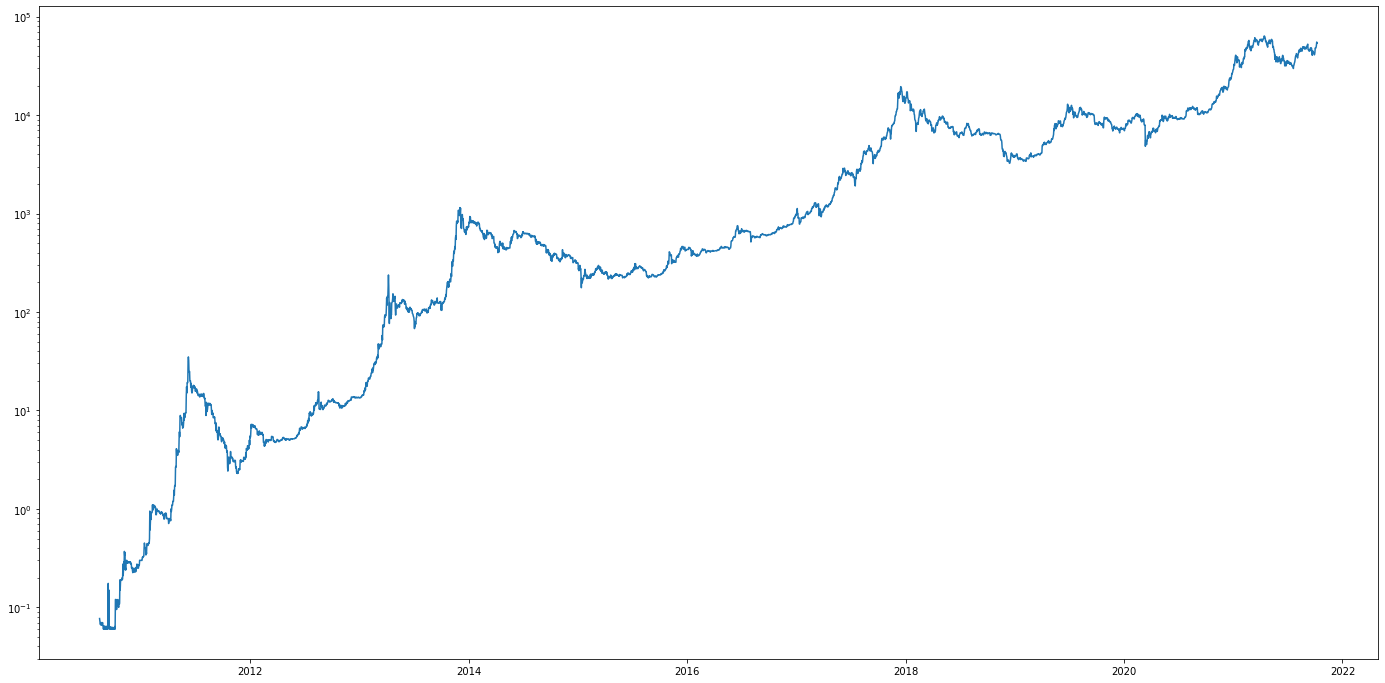

In [74]:
fig = plt.figure(figsize=(24, 12))
ax = plt.gca()
ax.set_yscale('log')
#Plots Closing Price of Bitcoin against time with the bull market support band
plt.plot(btcdata["Date"],btcdata["Value"])

From this chart, we can see that there are 4 distinct cycles in the price of bitcoin. The first one in 2011, followed by 2014, 2018 and finally 2021.

## Finding the peaks and bottoms of all 4 cycles

In [75]:
# define function for finding max and min for the cycle
def find_max_min(start_date,end_date):
    peak = btcdata.loc[btcdata["Date"].isin(pd.date_range(start_date, end_date))].max()
    bottom = btcdata.loc[btcdata["Date"].isin(pd.date_range(start_date, end_date))].min()
    print("Peak Date")
    print(str(btcdata.loc[btcdata['Value'] == peak["Value"],'Date'].max()))
    print("Peak Value")
    print("Value:\t" + str(peak["Value"]))
    print("Bottom Date")
    print(str(btcdata.loc[btcdata['Value'] == bottom["Value"],'Date'].max()))
    print("Bottom Value")
    print("Value:\t" + str(bottom["Value"]))
#First cycle 2010-2012
print("First cycle data")
find_max_min("2010-01-01","2012-01-01")
print(" ")
#Second cycle 2011-2014
print("Second cycle data")
find_max_min("2011-06-09","2015-01-01")
print(" ")
#Third cycle 2014-2019
print("Third cycle data")
find_max_min("2013-12-03","2019-01-01")
print(" ")
#Current cycle
print("Current cycle data")
find_max_min("2017-12-16","2022-01-01")

First cycle data
Peak Date
2011-06-09 00:00:00
Peak Value
Value:	35.0
Bottom Date
2010-10-07 00:00:00
Bottom Value
Value:	0.06
 
Second cycle data
Peak Date
2013-12-03 00:00:00
Peak Value
Value:	1151.0
Bottom Date
2011-11-20 00:00:00
Bottom Value
Value:	2.29
 
Third cycle data
Peak Date
2017-12-16 00:00:00
Peak Value
Value:	19498.6833333
Bottom Date
2015-01-13 00:00:00
Bottom Value
Value:	176.5
 
Current cycle data
Peak Date
2021-04-14 00:00:00
Peak Value
Value:	63554.44
Bottom Date
2018-12-15 00:00:00
Bottom Value
Value:	3242.42


## Split the data into its cycles
Cycle 1: 2010-10-07 to 2011-06-09

Cycle 2: 2011-11-20 to 2013-12-03

Cycle 3: 2015-01-13 to 2017-12-16

Cycle 4: 2018-12-15 to current day

In [77]:
# Define function to clean and filter the neccesary data from btcdata
def cycle_filter(start_date, end_date):
    # Filters the data to only get the data between the peaks and the bottom
    x = btcdata.loc[(btcdata["Date"] >= start_date) & (btcdata["Date"] <= end_date)]
    # Reindex the data
    x = x.reset_index(drop=True)
    # Calculate market cycle ROI
    x["ROI"] = (x["Value"]/x["Value"][0]) *100
    x["Days since bottom"] = x.index
    # Returns dataframe
    return x

cycle_1 = cycle_filter("2010-10-07","2011-06-09")
cycle_2 = cycle_filter("2011-11-20","2013-12-03")
cycle_3 = cycle_filter("2015-01-13","2017-12-16")
cycle_4 = cycle_filter("2018-12-15","2022-12-31")


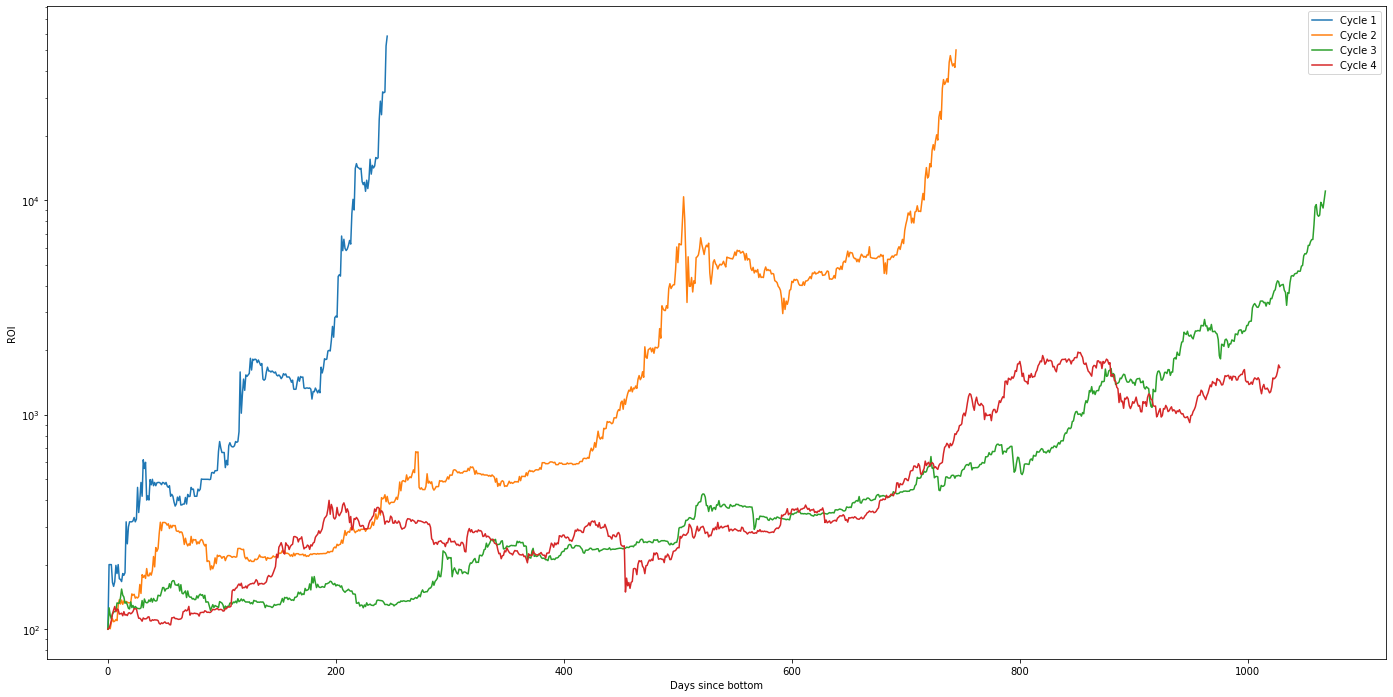

In [78]:
fig = plt.figure(figsize=(24, 12))
ax = plt.gca()
ax.set_yscale('log')
#Plots Closing Price of Bitcoin against time with the bull market support band
plt.xlabel("Days since bottom")
plt.ylabel("ROI")
plt.plot(cycle_1["Days since bottom"],cycle_1["ROI"],label='Cycle 1')
plt.plot(cycle_2["Days since bottom"],cycle_2["ROI"],label='Cycle 2')
plt.plot(cycle_3["Days since bottom"],cycle_3["ROI"],label='Cycle 3')
plt.plot(cycle_4["Days since bottom"],cycle_4["ROI"],label ='Cycle 4')
plt.legend()
plt.show()

Assuming cycle 4 is not over, we can conclude that from cycle 1 to cycle 3, not only is the length of the cycle increasing, the ROI from the market cycle bottom is also decreasing. 

With this information, we can tell that it is likely that the current cycle (cycle 4) will not keep pace with cycle 3. This can give us a gauge of when the value of BTC is overheated with respect to its previous cycles

## Predicting future market tops based on the rate of increase of cycle length and the rate of decrease of ROI 
Since there are only 3 data points, performing regression on this 3 points seems a bit pointless.

Instead, we can take a look at how long each cycle is, the change in length of the cycle.

We can also look at the decrease of ROI in each cycle, and try to project the likely time and value of the next market cycle top

# Defining Upper and Lower bounds using Logarithmic Regression
Most Logarithmic regression either only predicts the fairvalue, or just changes the parameters artificially to have a range of curves, which in my opinion doesn't really do much to predict the tops and the bottom of the market cycle.

In this part we will be fitting "bear market data" to define the lower bounds of bitcoins price action. We will also be fitting "peak data" to define upper bounds of bitcoins price action.

"Bear market data" will be defined as data from the bottom of the market cycle to when it last holds the bull market support band as support before breaking its previous all time highs

"Peak data" will be defined as the points where the market cycle peaked 

In [79]:
# Gets weekly data instead of daily
weeklydata = btcdata.groupby([pd.Grouper(key='Date', freq='W-MON')]).first().reset_index()
# Calculates the 20 week simple moving average
sma_20 = weeklydata["Value"].rolling(window = 20).mean()
weeklydata["SMA_20"] = sma_20
# Calculates the 21 week exponential moving average
ema_21 = weeklydata["Value"].ewm(span = 21, adjust = False).mean()
weeklydata["EMA_21"] = ema_21

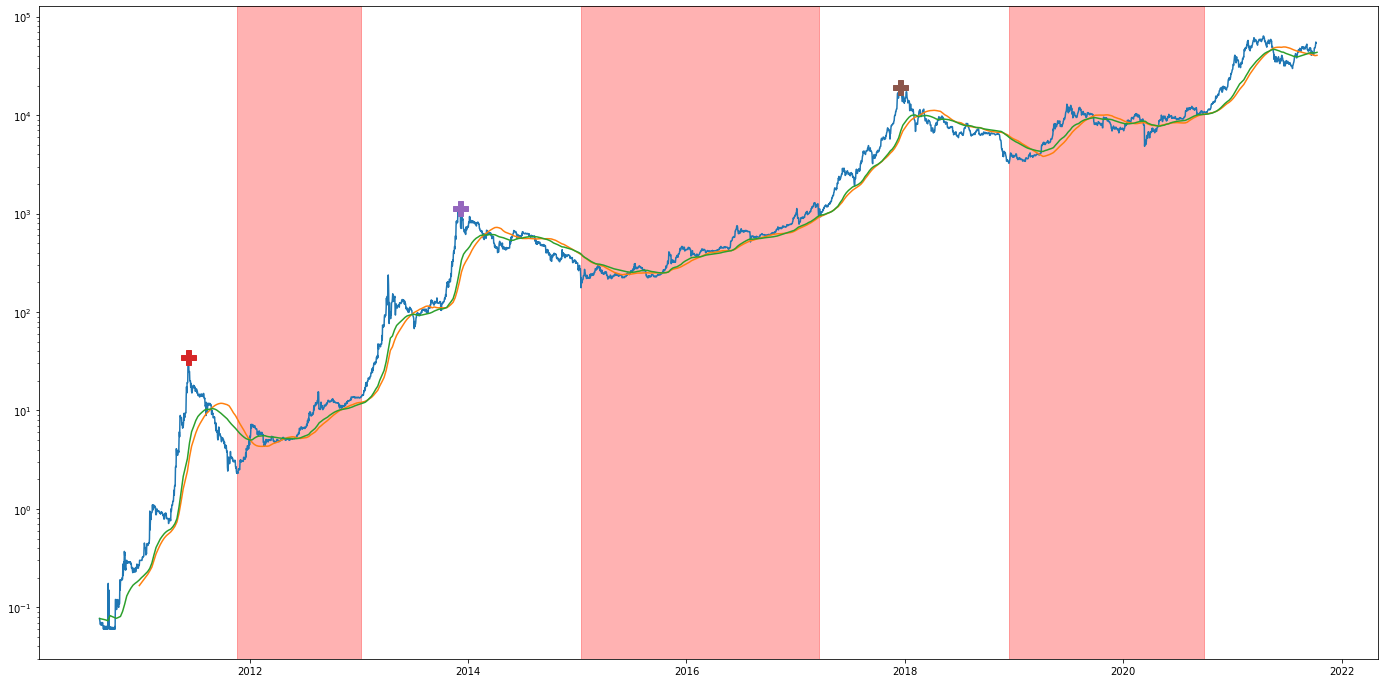

In [80]:
fig = plt.figure(figsize=(24, 12))
ax = plt.gca()
ax.set_yscale('log')
#Plots Closing Price of Bitcoin against time with the bull market support band
plt.plot(btcdata["Date"],btcdata["Value"])
plt.plot(weeklydata["Date"],weeklydata["SMA_20"])
plt.plot(weeklydata["Date"],weeklydata["EMA_21"])

# Vertical lines to show the date range of the bear market data
import datetime as dt
ax.axvspan(dt.datetime(2011, 11, 20), dt.datetime(2013, 1, 7), alpha=0.3, color='red')
ax.axvspan(dt.datetime(2015, 1, 13), dt.datetime(2017, 3, 20), alpha=0.3, color='red')
ax.axvspan(dt.datetime(2018, 12, 15), dt.datetime(2020, 9, 28), alpha=0.3, color='red')

# Highlights peak of the market cycle
plt.plot(dt.datetime(2011, 6, 9), 35.0, 'P',markersize=15)
plt.plot(dt.datetime(2013, 12, 3), 1151.0, 'P',markersize=15)
plt.plot(dt.datetime(2017, 12, 16), 19498.33,'P',markersize=15)

From this chart, we have manually picked out areas which fit the definition of our bear market (as highlighted in red) as well as identified market cycle peaks (highlighted with a "+").

We will be fitting a logarithmic regression model on these data points in order to get the upper and lower bound of the market cycle.

We have already identified peakdata previously.

Bear Market data:

2011-11-20 to 2013-01-07

2015-01-03 to 2017-03-20

2018-12-15 to 2020-09-28

In [83]:
peakdata.set_index('Date', inplace=True)
peakdata.head()

,Value
Date,
2011-06-09,35
2013-12-03,1151
2017-12-16,19498.683333


In [84]:
# Filters the data to only get the data between the peaks and the bottom
# Create one temporary data frame for each period before concatnating together
x = btcdata.loc[(btcdata["Date"] >= "2011-11-20") & (btcdata["Date"] <= "2013-01-07")]
y = btcdata.loc[(btcdata["Date"] >= "2015-01-03") & (btcdata["Date"] <= "2017-03-20")]
z = btcdata.loc[(btcdata["Date"] >= "2018-12-15") & (btcdata["Date"] <= "2020-09-28")]

[  6.62261669 -42.11378597 626.22423183]
[1.72374988e+00 1.74203206e+00 1.76047861e+00 ... 1.06215447e+06
 1.06365354e+06 1.06515440e+06]


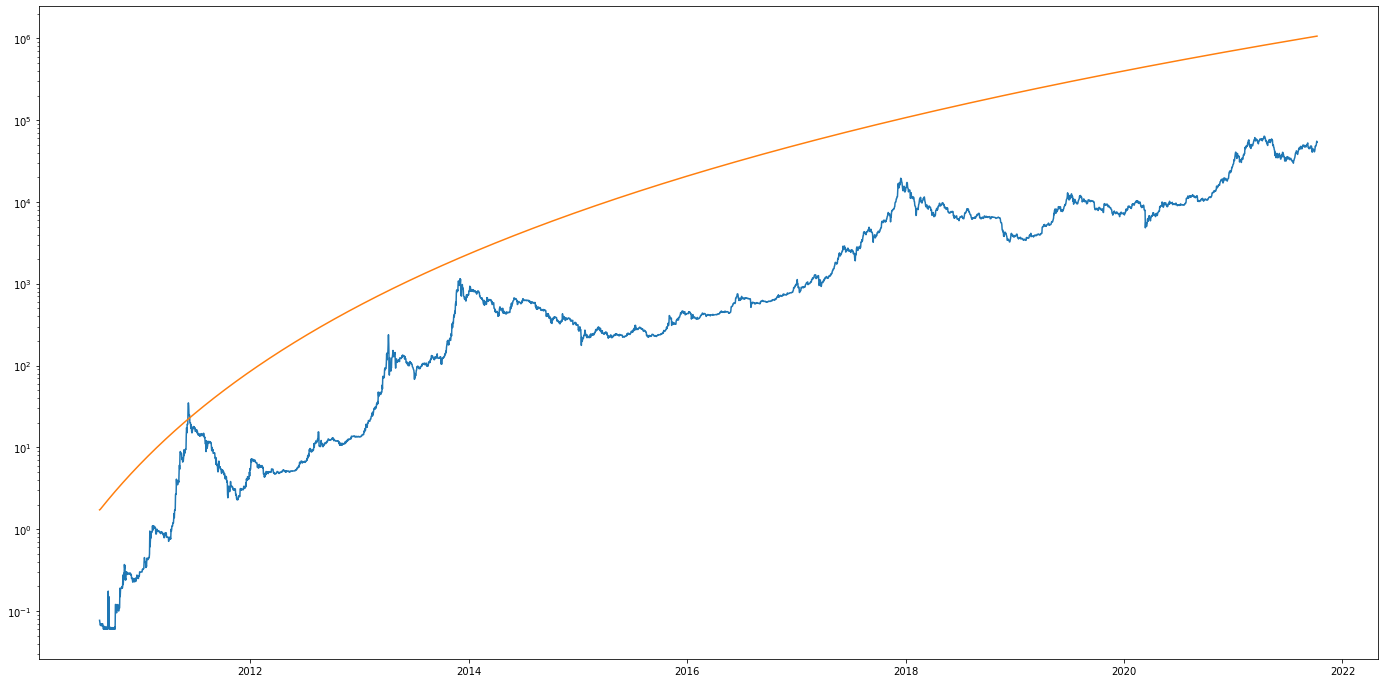

In [108]:
from scipy.optimize import curve_fit 

fig = plt.figure(figsize=(24, 12))
ax = plt.gca()
ax.set_yscale('log')
# Regression Fitting function
def log_reg(x,p1,p2,p3):
    #The formula for a logarithmic equation
    return p1*np.log(x+p3)+p2

xdata = np.array([x+1 for x in range(len(bear_market_data))])
ydata = np.log(bear_market_data["Value"])
xtest = np.array([x+1 for x in range(len(btcdata))])
#Fit the curve to the data
#Calculates the parameters to input in to log_reg function
p,cov = curve_fit(log_reg,xdata,ydata)
print(p)
fitted_data = log_reg(xtest,p[0],p[1],p[2])
# Issue now is that the regressed data removes the time in between.
# Is it possible to set bull phases as null and ignore?
#Plots Bitcoins data
plt.plot(btcdata["Date"],btcdata["Value"])
#Plots fitted line
# X axis is btcs date to prevent missing data
plt.plot(btcdata["Date"],np.exp(fitted_data))
print(np.exp(fitted_data))